# Comparing Machine Learning algorithms

In our paper, we chose the [Decision Tree classifier](http://scikit-learn.org/stable/modules/tree.html) provided by the [scikit-learn package](http://scikit-learn.org/) to test our Provenance Network Analytics approach on three applications (see the [Overview](Overview.ipynb) for links to those). It [implements an optimised version of the CART algorithm](http://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart) and performs quite fast compared to other classification algorithms.

In this notebook, we explore other classification algorithms also available in the scikit-learn package and compare their performance with Decision Tree classifiers in our three applications. The algorithms tested against Decision Tree classifiers are:
* [Support Vector Machine](http://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification) (`SVC`)
* [Nearest Neighbors Classification](http://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification) (`KNeighborsClassifier`)
* [Random Forests](http://scikit-learn.org/stable/modules/ensemble.html#random-forests) (`RandomForestClassifier`)
* [AdaBoost](http://scikit-learn.org/stable/modules/ensemble.html#adaboost) (`AdaBoostClassifier`)
* [Gradient Tree Boosting](http://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting) (`GradientBoostingClassifier`)
* [Gaussian Naive Bayes](http://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes) (`GaussianNB`),
* [Stochastic Gradient Descent](http://scikit-learn.org/stable/modules/sgd.html) (`SGDClassifier`)
* [Multi-layer Perceptron (neural network)](http://scikit-learn.org/stable/modules/neural_networks_supervised.html#classification) (`MLPClassifier`)

Since our main purpose is to gain a rough understanding of the relative benefit (accuracy) vs cost (time) of the above algorithms against Decision Tree classifiers, optimising the parameters of those algorithms is not in the scope of our experiments. We will use the default settings as specified by scikit-learn (which are normally sensible, anyway).

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from analytics import balance_smote

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Loading and preparing data

In [2]:
datasets = []  # list of the datasets to be tested with the above classifiers

### ProvStore Documents

See [Application 1 - ProvStore Documents.ipynb](Application%201%20-%20ProvStore%20Documents.ipynb) for more details.

In [3]:
df = pd.read_csv("provstore/data.csv")
datasets.append(('ProvStore', df))

### CollabMap Datasets

There are three datasets from CollabMap: buildings, routes, and route sets. See [Application 2 - CollabMap Data Quality.ipynb](Application%202%20-%20CollabMap%20Data%20Quality.ipynb) for more details.

In [4]:
df = pd.read_csv("collabmap/depgraphs.csv", index_col='id')
trust_threshold = 0.75
df['label'] = df.apply(lambda row: 'Trusted' if row.trust_value >= trust_threshold else 'Uncertain', axis=1)
df.drop('trust_value', axis=1, inplace=True)

datasets.append(('CollabMap/Buildings', df.filter(like="Building", axis=0)))
datasets.append(('CollabMap/Routes', df.filter(regex="^Route\d", axis=0)))
datasets.append(('CollabMap/Routesets', df.filter(like="RouteSet", axis=0)))

### Radiation Response Game Dataset

[Application 3 - RRG Messages.ipynb](Application%203%20-%20RRG%20Messages.ipynb)


In [5]:
filepath = lambda k: "rrg/depgraphs-%d.csv" % k
label = lambda l: 'other' if l != 'instruction' else l
df = pd.read_csv(filepath(11), index_col=0)
df.label = df.label.apply(label).astype('category')
datasets.append(('RRG/k=11', df))

## Testing and collecting measurements

First, we define the `Timer` class (below, taken from [this recipe](http://code.activestate.com/recipes/577896-benchmark-code-with-the-with-statement/)) to measure the computing time of training and classification. Note that this class allows us to disable garbage collection between measurements for more consistent results.

In [6]:
import gc
import timeit

class Timer:
    def __init__(self, timer=None, disable_gc=False, verbose=True):
        if timer is None:
            timer = timeit.default_timer
        self.timer = timer
        self.disable_gc = disable_gc
        self.gc_state = None
        self.verbose = verbose
        self.start = self.end = self.interval = None
        
    def __enter__(self):
        if self.disable_gc:
            self.gc_state = gc.isenabled()
            gc.disable()
        self.start = self.timer()
        return self

    def __exit__(self, *args):
        self.end = self.timer()
        if self.disable_gc and self.gc_state:
            gc.enable()
            self.gc_state = None            
        self.interval = self.end - self.start
        if self.verbose:
            print('time taken: %f seconds' % self.interval)

Next, we list the classifiers to be trained and tested in our experiment in `classifier_classes`.

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

classifier_classes = [
    DecisionTreeClassifier,
    SVC,
    KNeighborsClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    GaussianNB,
    QuadraticDiscriminantAnalysis,
    SGDClassifier,
    MLPClassifier
]

For each dataset, we balance the data using the SMOTE method (as described in [here](Cross%20Validation%20Code.ipynb)). We then carry out 10-fold cross validation tests, splitting the balanced dataset into training set and test set in 10 iterations. In each iteration, every classifier from the `classifier_classes` list above is trained and tested with the same training set and test set. The results are returned in a DataFrame whose rows tell us the dataset and classifier used along with its accuracy and computing time.

In [8]:
columns = ['dataset', 'classifier', 'accuracy', 'time']
def run_test_on(dataset_name, df):
    df = balance_smote(df)
    X = df.drop('label', axis=1)
    Y = df.label
    results = []
    
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    for train, test in skf.split(X, Y):
        for clf_cls in classifier_classes:
            classifier_name = clf_cls.__name__
            timer = Timer(disable_gc=True, verbose=False)
            with timer:
                clf = clf_cls()
                clf.fit(X.iloc[train], Y.iloc[train])
                accuracy_score = clf.score(X.iloc[test], Y.iloc[test])
            results.append((dataset_name, classifier_name, accuracy_score, timer.interval))
            print(results[-1])
            
    performance = pd.DataFrame(results, columns=columns)
    performance.classifier = performance.classifier.astype('category')
    return performance

Since we want to compare the other classifier against Decision Tree classifiers, we use the performance of the Decision Tree classifiers as the base line. The normalisation function below divides the accuracy and computing time of all classifiers by the mean accuracy and mean computing time of Decision Tree classifiers, respectively.

In [9]:
def normalise_accuracy_time(performance, baseline_classifier="DecisionTreeClassifier"):
    baseline_accuracy, baseline_time = performance[performance.classifier == baseline_classifier].mean()
    performance.accuracy = performance.accuracy / baseline_accuracy
    performance.time = performance.time / baseline_time

**Experiment**: Using the two functions above, the code below iterates over the 5 datasets loaded in the `datasets` list in the previous section, it run the performance test on each dataset, normalise the results, and append it to the `performance` DataFrame.

*Caution:* Running the code below may take about 50 minutes to finish.

In [10]:
performance = pd.DataFrame(columns=columns)
for dataset_name, df in datasets:
    results = run_test_on(dataset_name, df)
    normalise_accuracy_time(results)
    performance = performance.append(results, ignore_index=True)

Original data shapes: (13870, 22) (13870,)


/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be 

Balanced data shapes: (94430, 22) (94430,)
('ProvStore', 'DecisionTreeClassifier', 0.98433862433862429, 0.6282739690504968)
('ProvStore', 'SVC', 0.97724867724867726, 54.664983707945794)
('ProvStore', 'KNeighborsClassifier', 0.97798941798941796, 0.6841244460083544)
('ProvStore', 'RandomForestClassifier', 0.98529100529100533, 0.9375908700749278)
('ProvStore', 'AdaBoostClassifier', 0.24137566137566138, 11.694342364091426)


/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:583: RuntimeWarning: overflow encountered in double_scalars
  tree.value[leaf, 0, 0] = numerator / denominator
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/utils/extmath.py:410: RuntimeWarning: invalid value encountered in subtract
  out = np.log(np.sum(np.exp(arr - vmax), axis=0))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:558: RuntimeWarning: invalid value encountered in multiply
  return np.sum(-1 * sample_weight * (Y * pred).sum(axis=1) +


('ProvStore', 'GradientBoostingClassifier', 0.96719576719576716, 177.97722859308124)
('ProvStore', 'GaussianNB', 0.63534391534391532, 0.1893952637910843)


/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:722: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


('ProvStore', 'QuadraticDiscriminantAnalysis', 0.071428571428571425, 0.2196116358973086)
('ProvStore', 'SGDClassifier', 0.58592592592592596, 0.95608109398745)
('ProvStore', 'MLPClassifier', 0.97873015873015878, 7.766927886987105)
('ProvStore', 'DecisionTreeClassifier', 0.98317460317460315, 0.6422885661013424)
('ProvStore', 'SVC', 0.97523809523809524, 56.62782682082616)
('ProvStore', 'KNeighborsClassifier', 0.98232804232804238, 0.7215720429085195)
('ProvStore', 'RandomForestClassifier', 0.9838095238095238, 0.9315545791760087)
('ProvStore', 'AdaBoostClassifier', 0.23883597883597885, 12.325766609050333)
('ProvStore', 'GradientBoostingClassifier', 0.98126984126984129, 205.08686965494417)
('ProvStore', 'GaussianNB', 0.63195767195767194, 0.19474898418411613)


/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:722: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


('ProvStore', 'QuadraticDiscriminantAnalysis', 0.071428571428571425, 0.21984002296812832)
('ProvStore', 'SGDClassifier', 0.63460317460317461, 1.0515488469973207)
('ProvStore', 'MLPClassifier', 0.97894179894179889, 17.490266302833334)
('ProvStore', 'DecisionTreeClassifier', 0.98042328042328042, 0.7004924649372697)
('ProvStore', 'SVC', 0.97492063492063497, 60.00700272107497)
('ProvStore', 'KNeighborsClassifier', 0.97492063492063497, 0.7562006588559598)
('ProvStore', 'RandomForestClassifier', 0.98137566137566135, 1.017202251125127)
('ProvStore', 'AdaBoostClassifier', 0.24116402116402116, 12.618408649927005)
('ProvStore', 'GradientBoostingClassifier', 0.98052910052910058, 191.60630124108866)
('ProvStore', 'GaussianNB', 0.63100529100529101, 0.18379174708388746)


/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:722: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


('ProvStore', 'QuadraticDiscriminantAnalysis', 0.071428571428571425, 0.20788549608550966)
('ProvStore', 'SGDClassifier', 0.56105820105820103, 0.9839116588700563)
('ProvStore', 'MLPClassifier', 0.97915343915343911, 13.864243179094046)
('ProvStore', 'DecisionTreeClassifier', 0.982010582010582, 0.6382025182247162)
('ProvStore', 'SVC', 0.97587301587301589, 54.57399194291793)
('ProvStore', 'KNeighborsClassifier', 0.982010582010582, 0.7025791951455176)
('ProvStore', 'RandomForestClassifier', 0.98370370370370375, 0.9280164430383593)
('ProvStore', 'AdaBoostClassifier', 0.24359788359788359, 12.009571711998433)
('ProvStore', 'GradientBoostingClassifier', 0.98243386243386244, 187.4014346669428)
('ProvStore', 'GaussianNB', 0.64074074074074072, 0.1926153169479221)


/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:722: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


('ProvStore', 'QuadraticDiscriminantAnalysis', 0.071428571428571425, 0.20157398888841271)
('ProvStore', 'SGDClassifier', 0.66264550264550259, 0.9724252661690116)
('ProvStore', 'MLPClassifier', 0.97978835978835976, 24.709092132980004)
('ProvStore', 'DecisionTreeClassifier', 0.98116402116402113, 0.6377822048962116)
('ProvStore', 'SVC', 0.97576719576719573, 55.80485440604389)
('ProvStore', 'KNeighborsClassifier', 0.97798941798941796, 0.7254003388807178)
('ProvStore', 'RandomForestClassifier', 0.98222222222222222, 0.9230234220158309)
('ProvStore', 'AdaBoostClassifier', 0.23904761904761904, 12.039744910085574)
('ProvStore', 'GradientBoostingClassifier', 0.98126984126984129, 189.90324166906066)
('ProvStore', 'GaussianNB', 0.63417989417989418, 0.1964319630060345)


/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:722: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


('ProvStore', 'QuadraticDiscriminantAnalysis', 0.071428571428571425, 0.20328653207980096)
('ProvStore', 'SGDClassifier', 0.39915343915343915, 0.9719647150486708)
('ProvStore', 'MLPClassifier', 0.97746031746031747, 11.966222131159157)
('ProvStore', 'DecisionTreeClassifier', 0.97838066977532856, 0.6494953420478851)
('ProvStore', 'SVC', 0.97329376854599403, 55.16984712891281)
('ProvStore', 'KNeighborsClassifier', 0.9358838490885969, 0.7060083199758083)
('ProvStore', 'RandomForestClassifier', 0.97965239508266211, 0.9225535469595343)
('ProvStore', 'AdaBoostClassifier', 0.24258160237388723, 12.090174629818648)
('ProvStore', 'GradientBoostingClassifier', 0.97700296735905046, 190.71470193611458)
('ProvStore', 'GaussianNB', 0.63342518016108518, 0.19647060008719563)


/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:722: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


('ProvStore', 'QuadraticDiscriminantAnalysis', 0.071428571428571425, 0.20877749798819423)
('ProvStore', 'SGDClassifier', 0.40525646460364562, 0.9651722251437604)
('ProvStore', 'MLPClassifier', 0.97806273844849512, 28.429929216858)
('ProvStore', 'DecisionTreeClassifier', 0.98346757100466298, 0.6399862139951438)
('ProvStore', 'SVC', 0.97657905892327257, 54.96170974592678)
('ProvStore', 'KNeighborsClassifier', 0.97912250953793978, 0.7141891859937459)
('ProvStore', 'RandomForestClassifier', 0.98389147944044086, 0.918852160917595)
('ProvStore', 'AdaBoostClassifier', 0.24459516744383214, 12.048601221991703)
('ProvStore', 'GradientBoostingClassifier', 0.98325561678677409, 177.18023935798556)
('ProvStore', 'GaussianNB', 0.6300339126748622, 0.18278415803797543)


/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:722: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


('ProvStore', 'QuadraticDiscriminantAnalysis', 0.071428571428571425, 0.1987031849566847)
('ProvStore', 'SGDClassifier', 0.62484103433658333, 0.9174390151165426)
('ProvStore', 'MLPClassifier', 0.98071216617210677, 17.275759185198694)
('ProvStore', 'DecisionTreeClassifier', 0.97997032640949555, 0.6224692738614976)
('ProvStore', 'SVC', 0.97286986011021614, 53.502078492892906)
('ProvStore', 'KNeighborsClassifier', 0.97456549385332769, 0.6719589701388031)
('ProvStore', 'RandomForestClassifier', 0.98050021195421788, 0.8765174869913608)
('ProvStore', 'AdaBoostClassifier', 0.23749470114455279, 11.357924479059875)
('ProvStore', 'GradientBoostingClassifier', 0.95803306485799067, 171.1285808600951)
('ProvStore', 'GaussianNB', 0.63183552352691819, 0.1877018720842898)


/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:722: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


('ProvStore', 'QuadraticDiscriminantAnalysis', 0.071428571428571425, 0.1983064040541649)
('ProvStore', 'SGDClassifier', 0.14444679949130987, 0.9076564291026443)
('ProvStore', 'MLPClassifier', 0.97742687579482834, 18.265281066996977)
('ProvStore', 'DecisionTreeClassifier', 0.98050021195421788, 0.6138428659178317)
('ProvStore', 'SVC', 0.97424756252649425, 52.9012228010688)
('ProvStore', 'KNeighborsClassifier', 0.97965239508266211, 0.6679396738763899)
('ProvStore', 'RandomForestClassifier', 0.98134802882577366, 0.8896840901579708)
('ProvStore', 'AdaBoostClassifier', 0.20199236964815601, 11.323103261878714)
('ProvStore', 'GradientBoostingClassifier', 0.97986434930055111, 171.47252991888672)
('ProvStore', 'GaussianNB', 0.63543874523103006, 0.18165320483967662)


/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:722: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


('ProvStore', 'QuadraticDiscriminantAnalysis', 0.071428571428571425, 0.19786123000085354)
('ProvStore', 'SGDClassifier', 0.54069520983467567, 0.9000884960405529)
('ProvStore', 'MLPClassifier', 0.97816871555743956, 22.837120848009363)
('ProvStore', 'DecisionTreeClassifier', 0.98081814328105132, 0.6138826361857355)
('ProvStore', 'SVC', 0.97371767698177192, 53.480530600994825)
('ProvStore', 'KNeighborsClassifier', 0.97615515048749468, 0.6645809879992157)
('ProvStore', 'RandomForestClassifier', 0.98166596015260699, 0.8876681609544903)
('ProvStore', 'AdaBoostClassifier', 0.24003815175922, 11.361000906908885)
('ProvStore', 'GradientBoostingClassifier', 0.97816871555743956, 171.13530291896313)
('ProvStore', 'GaussianNB', 0.63702840186519716, 0.18148943991400301)


/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:722: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


('ProvStore', 'QuadraticDiscriminantAnalysis', 0.071428571428571425, 0.19680562405847013)
('ProvStore', 'SGDClassifier', 0.58488766426451888, 0.8985274231527001)
('ProvStore', 'MLPClassifier', 0.9773208986858839, 15.01476671709679)
Original data shapes: (5175, 22) (5175,)
Balanced data shapes: (8982, 22) (8982,)
('CollabMap/Buildings', 'DecisionTreeClassifier', 0.88777777777777778, 0.016987378941848874)
('CollabMap/Buildings', 'SVC', 0.88777777777777778, 0.654363403795287)
('CollabMap/Buildings', 'KNeighborsClassifier', 0.88555555555555554, 0.05372064607217908)
('CollabMap/Buildings', 'RandomForestClassifier', 0.88777777777777778, 0.034585230983793736)
('CollabMap/Buildings', 'AdaBoostClassifier', 0.88666666666666671, 0.5658830350730568)
('CollabMap/Buildings', 'GradientBoostingClassifier', 0.88666666666666671, 0.3947491920553148)
('CollabMap/Buildings', 'GaussianNB', 0.81444444444444442, 0.012314618099480867)
('CollabMap/Buildings', 'QuadraticDiscriminantAnalysis', 0.5, 0.018667222931

('CollabMap/Buildings', 'AdaBoostClassifier', 0.91091314031180404, 0.565354464109987)
('CollabMap/Buildings', 'GradientBoostingClassifier', 0.9131403118040089, 0.39780942001380026)
('CollabMap/Buildings', 'GaussianNB', 0.8229398663697105, 0.012065473012626171)
('CollabMap/Buildings', 'QuadraticDiscriminantAnalysis', 0.5, 0.015248610870912671)
('CollabMap/Buildings', 'SGDClassifier', 0.5, 0.008899723878130317)
('CollabMap/Buildings', 'MLPClassifier', 0.90200445434298437, 0.43090497702360153)
Original data shapes: (4997, 22) (4997,)
Balanced data shapes: (7816, 22) (7816,)
('CollabMap/Routes', 'DecisionTreeClassifier', 0.97186700767263423, 0.020979539956897497)
('CollabMap/Routes', 'SVC', 0.95524296675191811, 0.44960711104795337)
('CollabMap/Routes', 'KNeighborsClassifier', 0.97186700767263423, 0.04359858902171254)
('CollabMap/Routes', 'RandomForestClassifier', 0.97058823529411764, 0.0408935840241611)
('CollabMap/Routes', 'AdaBoostClassifier', 0.95524296675191811, 0.5249527900014073)
('C

('CollabMap/Routes', 'SVC', 0.96025641025641029, 0.4666906089987606)
('CollabMap/Routes', 'KNeighborsClassifier', 0.96153846153846156, 0.04472280712798238)
('CollabMap/Routes', 'RandomForestClassifier', 0.982051282051282, 0.04239291697740555)
('CollabMap/Routes', 'AdaBoostClassifier', 0.95641025641025645, 0.5244158839341253)
('CollabMap/Routes', 'GradientBoostingClassifier', 0.96410256410256412, 0.3946032510139048)
('CollabMap/Routes', 'GaussianNB', 0.87820512820512819, 0.010561563074588776)
('CollabMap/Routes', 'QuadraticDiscriminantAnalysis', 0.5, 0.013449113117530942)
('CollabMap/Routes', 'SGDClassifier', 0.86282051282051286, 0.007984800031408668)
('CollabMap/Routes', 'MLPClassifier', 0.92307692307692313, 0.6299189948476851)
Original data shapes: (4710, 22) (4710,)
Balanced data shapes: (6038, 22) (6038,)
('CollabMap/Routesets', 'DecisionTreeClassifier', 0.95364238410596025, 0.022387400036677718)
('CollabMap/Routesets', 'SVC', 0.95033112582781454, 0.2934609961230308)
('CollabMap/Rou

('CollabMap/Routesets', 'GradientBoostingClassifier', 0.96192052980132448, 0.34344770293682814)
('CollabMap/Routesets', 'GaussianNB', 0.72847682119205293, 0.00797056290321052)
('CollabMap/Routesets', 'QuadraticDiscriminantAnalysis', 0.67052980132450335, 0.009791651042178273)
('CollabMap/Routesets', 'SGDClassifier', 0.92715231788079466, 0.006243706913664937)
('CollabMap/Routesets', 'MLPClassifier', 0.92549668874172186, 0.5744108147919178)
('CollabMap/Routesets', 'DecisionTreeClassifier', 0.9700996677740864, 0.02246780996210873)
('CollabMap/Routesets', 'SVC', 0.95182724252491691, 0.29382482497021556)
('CollabMap/Routesets', 'KNeighborsClassifier', 0.95681063122923593, 0.017376876901835203)
('CollabMap/Routesets', 'RandomForestClassifier', 0.96677740863787376, 0.04088546405546367)
('CollabMap/Routesets', 'AdaBoostClassifier', 0.94850498338870437, 0.4093765649013221)
('CollabMap/Routesets', 'GradientBoostingClassifier', 0.96511627906976749, 0.33941993792541325)
('CollabMap/Routesets', 'Gau

/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:722: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: invalid value


('RRG/k=11', 'GradientBoostingClassifier', 0.75, 0.041996494168415666)
('RRG/k=11', 'GaussianNB', 0.875, 0.001696938183158636)
('RRG/k=11', 'QuadraticDiscriminantAnalysis', 0.5, 0.0019595439080148935)
('RRG/k=11', 'SGDClassifier', 0.75, 0.0013615519274026155)
('RRG/k=11', 'MLPClassifier', 0.5, 0.006086983950808644)
('RRG/k=11', 'DecisionTreeClassifier', 1.0, 0.0012267990969121456)
('RRG/k=11', 'SVC', 1.0, 0.0015221829526126385)
('RRG/k=11', 'KNeighborsClassifier', 1.0, 0.001708680996671319)
('RRG/k=11', 'RandomForestClassifier', 0.875, 0.011418401962146163)
('RRG/k=11', 'AdaBoostClassifier', 1.0, 0.06060530710965395)
('RRG/k=11', 'GradientBoostingClassifier', 0.875, 0.040803274139761925)
('RRG/k=11', 'GaussianNB', 1.0, 0.001698334002867341)
('RRG/k=11', 'QuadraticDiscriminantAnalysis', 0.5, 0.00198193802498281)
('RRG/k=11', 'SGDClassifier', 0.625, 0.0013500789646059275)
('RRG/k=11', 'MLPClassifier', 0.5, 0.0035098791122436523)
('RRG/k=11', 'DecisionTreeClassifier', 0.875, 0.0012260228

/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:722: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: invalid value

('RRG/k=11', 'AdaBoostClassifier', 1.0, 0.059438828844577074)
('RRG/k=11', 'GradientBoostingClassifier', 1.0, 0.04061459400691092)
('RRG/k=11', 'GaussianNB', 0.875, 0.0016240121331065893)
('RRG/k=11', 'QuadraticDiscriminantAnalysis', 0.5, 0.0018182999920099974)
('RRG/k=11', 'SGDClassifier', 0.75, 0.001461958047002554)
('RRG/k=11', 'MLPClassifier', 0.5, 0.003513803007081151)
('RRG/k=11', 'DecisionTreeClassifier', 0.875, 0.0012086979113519192)
('RRG/k=11', 'SVC', 0.75, 0.0013758628629148006)
('RRG/k=11', 'KNeighborsClassifier', 0.875, 0.0016258079558610916)
('RRG/k=11', 'RandomForestClassifier', 0.875, 0.011359950061887503)
('RRG/k=11', 'AdaBoostClassifier', 0.875, 0.059313332894816995)
('RRG/k=11', 'GradientBoostingClassifier', 0.875, 0.04020914598368108)
('RRG/k=11', 'GaussianNB', 0.375, 0.0016456039156764746)
('RRG/k=11', 'QuadraticDiscriminantAnalysis', 0.5, 0.0017497390508651733)
('RRG/k=11', 'SGDClassifier', 0.5, 0.0018051520455628633)
('RRG/k=11', 'MLPClassifier', 0.5, 0.006517163

/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:722: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: invalid value

('RRG/k=11', 'AdaBoostClassifier', 0.75, 0.061202650889754295)
('RRG/k=11', 'GradientBoostingClassifier', 0.5, 0.04074292699806392)
('RRG/k=11', 'GaussianNB', 1.0, 0.0016191198956221342)
('RRG/k=11', 'QuadraticDiscriminantAnalysis', 0.5, 0.0019401400350034237)
('RRG/k=11', 'SGDClassifier', 0.5, 0.001365691889077425)
('RRG/k=11', 'MLPClassifier', 0.75, 0.004001813009381294)
('RRG/k=11', 'DecisionTreeClassifier', 1.0, 0.0012713468167930841)
('RRG/k=11', 'SVC', 0.875, 0.001363782910630107)
('RRG/k=11', 'KNeighborsClassifier', 0.875, 0.0017453581094741821)
('RRG/k=11', 'RandomForestClassifier', 0.875, 0.011464271927252412)
('RRG/k=11', 'AdaBoostClassifier', 0.875, 0.05868331203237176)
('RRG/k=11', 'GradientBoostingClassifier', 0.875, 0.04217184684239328)
('RRG/k=11', 'GaussianNB', 0.75, 0.0016572889871895313)
('RRG/k=11', 'QuadraticDiscriminantAnalysis', 0.5, 0.0017651650123298168)
('RRG/k=11', 'SGDClassifier', 0.5, 0.001581565011292696)
('RRG/k=11', 'MLPClassifier', 0.5, 0.003565573133528

/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:722: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: invalid value

('RRG/k=11', 'AdaBoostClassifier', 0.66666666666666663, 0.0598211910109967)
('RRG/k=11', 'GradientBoostingClassifier', 0.66666666666666663, 0.04210941190831363)
('RRG/k=11', 'GaussianNB', 0.66666666666666663, 0.0017534890212118626)
('RRG/k=11', 'QuadraticDiscriminantAnalysis', 0.5, 0.0018699930515140295)
('RRG/k=11', 'SGDClassifier', 0.5, 0.0013889288529753685)
('RRG/k=11', 'MLPClassifier', 0.5, 0.006494611036032438)
('RRG/k=11', 'DecisionTreeClassifier', 0.83333333333333337, 0.0012138860765844584)
('RRG/k=11', 'SVC', 0.83333333333333337, 0.0013793460093438625)
('RRG/k=11', 'KNeighborsClassifier', 0.83333333333333337, 0.0017623151652514935)
('RRG/k=11', 'RandomForestClassifier', 0.83333333333333337, 0.011491863988339901)
('RRG/k=11', 'AdaBoostClassifier', 0.83333333333333337, 0.05878868489526212)
('RRG/k=11', 'GradientBoostingClassifier', 0.83333333333333337, 0.041642566910013556)
('RRG/k=11', 'GaussianNB', 0.66666666666666663, 0.0016783999744802713)
('RRG/k=11', 'QuadraticDiscriminant

/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:722: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/Users/tdh/.virtualenvs/datasets-provanalytics-dmkd/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:719: RuntimeWarning: invalid value

Saving the results to a file so that we will not need to run the lengthy tests above again the next time:

In [11]:
performance.to_pickle('performance.pkl')

In [12]:
performance = pd.read_pickle('performance.pkl')

## Charting the relative performance

In this section, we plot the measurements (accuracy and time) collected above to compare the relative difference in the performance of the tested against that of Decision Tree classifiers.

Since we have normalised the measurements agains those of Decision Tree classifiers, the measurements of Decision Tree classifiers average at 1.0 (for both accuracy and time). Therefore, to simplify the charts, we remove them from the plotted data.

In [13]:
# Dropping measurements of DecisionTreeClassifier
performance = performance[~(performance.classifier == 'DecisionTreeClassifier')]

In [14]:
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

### Comparing Accuracy Score

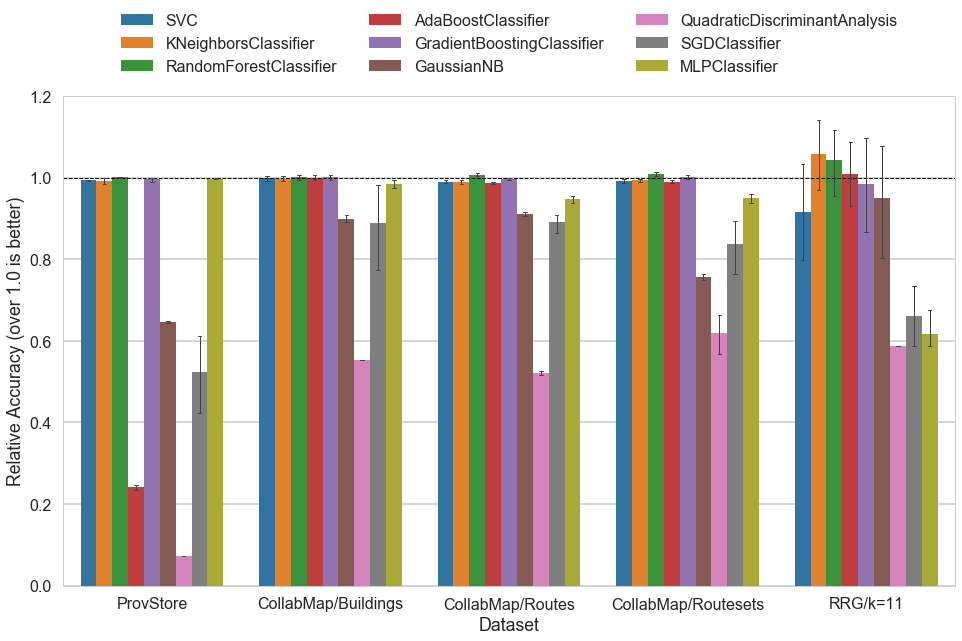

In [15]:
plot = sns.barplot(x='dataset', y='accuracy', hue='classifier', data=performance, errwidth=1, capsize=0.02)
plot.hlines(1, -0.5, 4.5, linestyle='--', linewidth=1)
plot.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
plot.set_xlabel('Dataset')
plot.set_ylabel('Relative Accuracy (over 1.0 is better)')
plot.figure.set_size_inches(16, 9)

**Results**: The chart above shows that, with *all* the 5 datasets, *all* other classifiers yield the same level of accuracy as that of Decision Tree classifiers (1.0) or worse, with the *only exception* of the performance of Random Forest classifiers on the `CollabMap/Routes` and `CollabMap/Routesets` datasets. Having said that, the improvement in accuracy is only about 1% as shown below.

Some algorithms have better mean accuracy on the `RRG/k=11` dataset, but the 95% confidence intervals are too broad for us to say conclusively that they are actually better than the decision tree classifier.

In [16]:
performance[
    (performance.classifier == 'RandomForestClassifier') & (performance.dataset == 'CollabMap/Routes')
].mean()

accuracy    1.006878
time        1.944126
dtype: float64

In [17]:
performance[
    (performance.classifier == 'RandomForestClassifier') & (performance.dataset == 'CollabMap/Routesets')
].mean()

accuracy    1.008296
time        1.817231
dtype: float64

### Comparing Computing Time

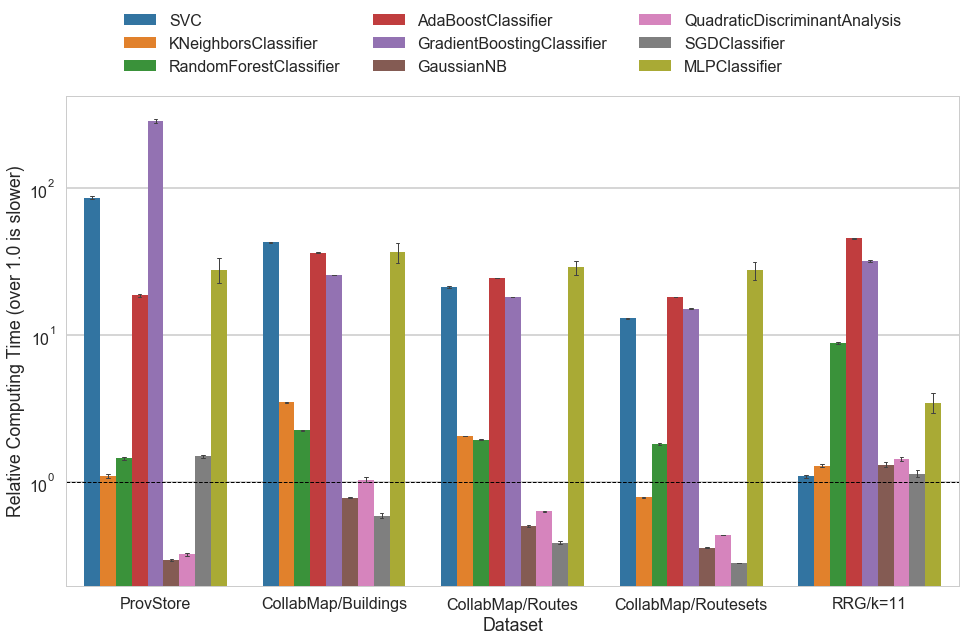

In [18]:
plot = sns.barplot(x='dataset', y='time', hue='classifier', data=performance, errwidth=1, capsize=0.02)
plot.figure.set_size_inches(16, 9)
plot.hlines(1, -0.5, 4.5, linestyle='--', linewidth=1)
plot.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
plot.set_xlabel('Dataset')
plot.set_ylabel('Relative Computing Time (over 1.0 is slower)')
plot.set_yscale('log')

**Results**: The algorithms that are faster than decision tree classification in some cases (GaussianNB, QuadraticDiscriminantAnalysis, and SGDCClassifier) are those that performed significantly worse in our previous chart (across 5 datasets). The slightly more accurate algorithm (RandomForestClassifier) takes nearly double the time compared to the decision tree classifier.

**Conclusion**: From the available classification algorithms provided by the scikit-learn package, DecisionTreeClassifier is the best choice for our work as it is fast and provides high accuracy on the datasets that we investigate.